In [1]:
import sys, h5py, pdb,time, glob, os
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from scipy import interpolate
from matplotlib import ticker, patches
sys.path.append('/mnt/home/jstern/gizmo_analysis/pysrc/')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'
import matplotlib.image as mpimg

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = wd.basedir+'../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
#simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e3_n10_NoLowCool'
#simname_lowres = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking'
simname = 'OVI'
vc = 80. *un.km/un.s
Rcirc = 6.5*un.kpc
snapshot_dt_Myr = 10
simdir = '/mnt/home/jstern/ceph/sim_outputs/vc80/output/'
#simdir_lowres = wd.simdir+'/%s/output/'%simname_lowres

In [5]:
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
sim.z = 0 #for cooling function
print(sim.galaxyname, sim.Nsnapshots())

OVI 499


In [6]:
figdir = '/mnt/home/jstern/ceph/sim_outputs/vc80/figures/'

In [7]:
iSnapshot = 10
snapshot = sim.getSnapshot(iSnapshot)
prof = sim.getProfiler(iSnapshot)

In [8]:
Rs = (snapshot.coords()[:,:2]**2).sum(axis=1)**0.5
Omegas = snapshot.js()[:,2] / Rs**2

saved j_vec_x
saved j_vec_y
saved j_vec_z
saved j_vec_weight


/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:737: RuntimeWarning: invalid value encountered in divide
  self.save('j_vec_x'+suffix, hist[1,:] / hist[0,:])
/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:738: RuntimeWarning: invalid value encountered in divide
  self.save('j_vec_y'+suffix, hist[2,:] / hist[0,:])
/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:739: RuntimeWarning: invalid value encountered in divide
  self.save('j_vec_z'+suffix, hist[3,:] / hist[0,:])


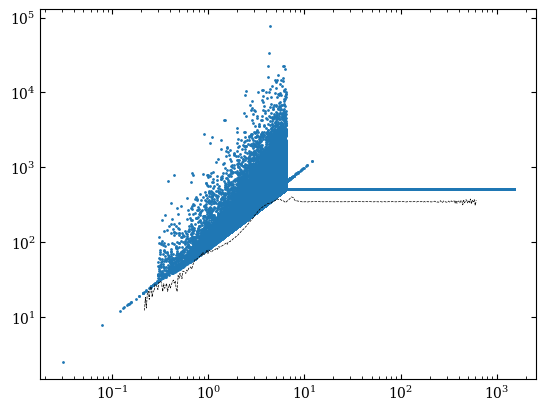

In [9]:
f_init = h5py.File('/mnt/home/jstern/ceph/sim_outputs/vc80/ICs/init_snapshot.hdf5')
f0 = h5py.File(simdir+'snapshot_000.hdf5')
for f in (f0,):#f_init:
    vs     = f['PartType0']['Velocities']
    coords =  f['PartType0']['Coordinates']
    js = np.array([coords[:,1] * vs[:,2] - coords[:,2] * vs[:,1],
                   coords[:,2] * vs[:,0] - coords[:,0] * vs[:,2],
                   coords[:,0] * vs[:,1] - coords[:,1] * vs[:,0]]).T
    Rs = (coords[:,:2]**2).sum(axis=1)**0.5
    rs = (coords[:,:3]**2).sum(axis=1)**0.5
    Omegas = js[:,2]/Rs**2
    pl.scatter(rs, Omegas*rs**2,s = 1)
pl.yscale('symlog')
pl.xscale('log')
_rs = 10.**np.arange(-1,3,0.01)
pl.plot(prof.rs_midbins(),prof.jProfile(),c='k',ls='--',lw=0.5)
#pl.ylim(-200,200)

/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:878: RuntimeWarning: invalid value encountered in divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved nHs_MW
saved Ts_MW
saved masses_MW
saved t_cool_MW


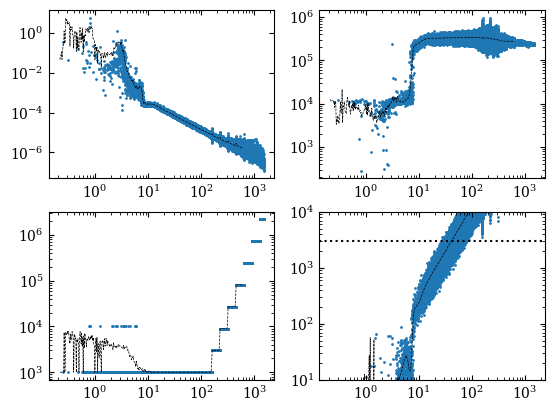

In [10]:
pl.figure()
rs = snapshot.rs()
for iPanel in range(4):
    ax = pl.subplot(2,2,iPanel+1)
    attr = ('nHs','Ts','masses','t_cool')[iPanel]
    pl.scatter(rs[::100], getattr(snapshot,attr)()[::100],s=1)
    pl.plot(prof.rs_midbins(),prof.profile1D(attr,weight='MW'),c='k',lw=0.5,ls='--')
    pl.loglog()
    if iPanel==3: 
        pl.axhline(3000,c='k',ls=':')
        pl.ylim(10,1e4)

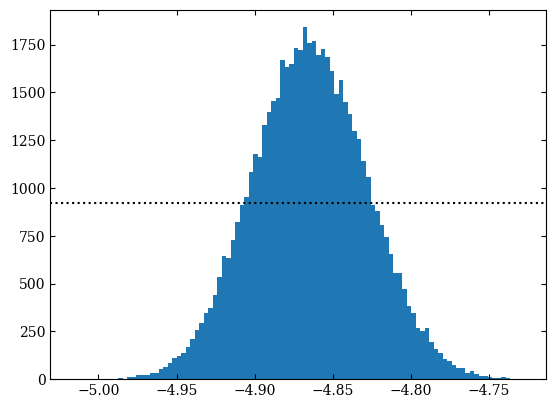

In [11]:
inds = (rs<101)&(rs>100)
t = pl.hist(log(snapshot.nHs()[inds]),bins=100)
pl.axhline(t[0].max()/2,c='k',ls=':')
#pl.xlim(-5,-3)

50
100
150
200
250
300
350
400
450
500


IndexError: list index out of range

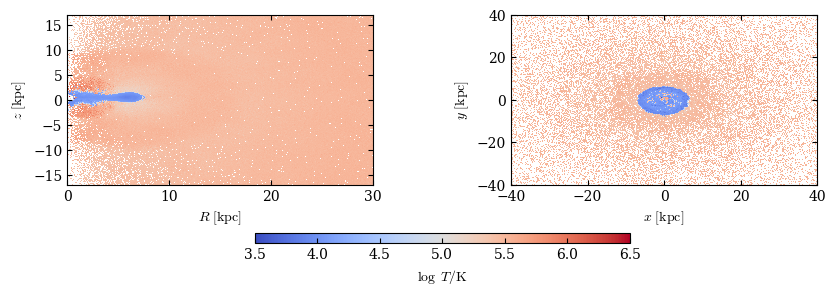

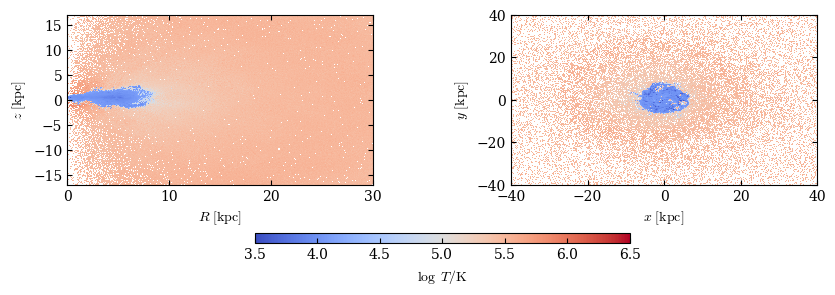

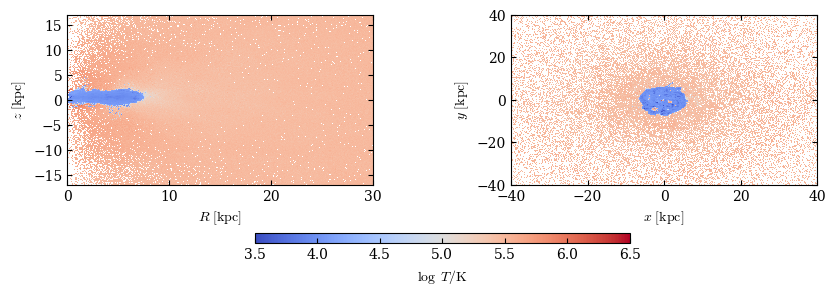

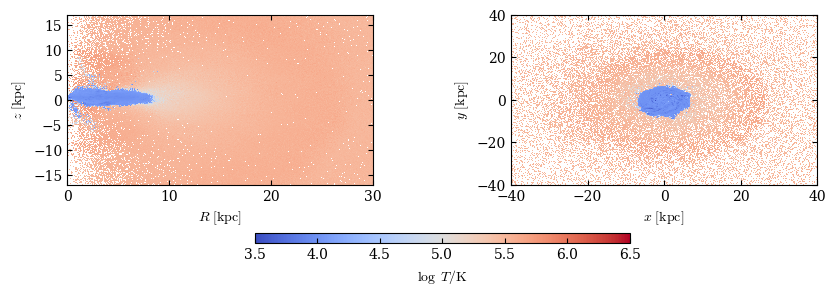

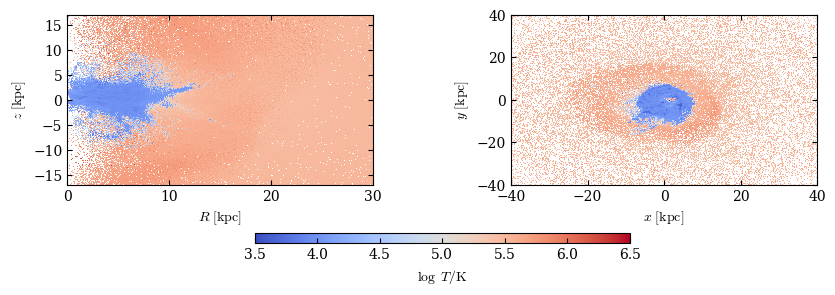

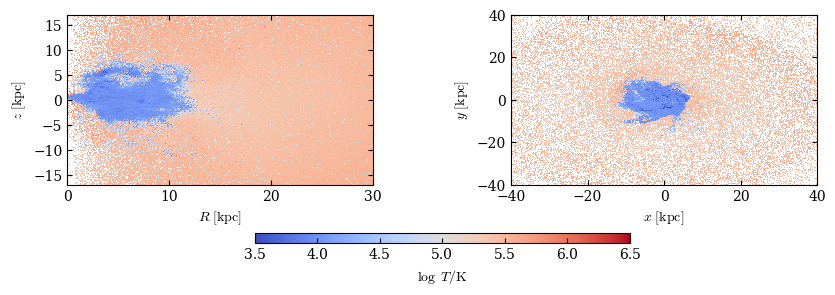

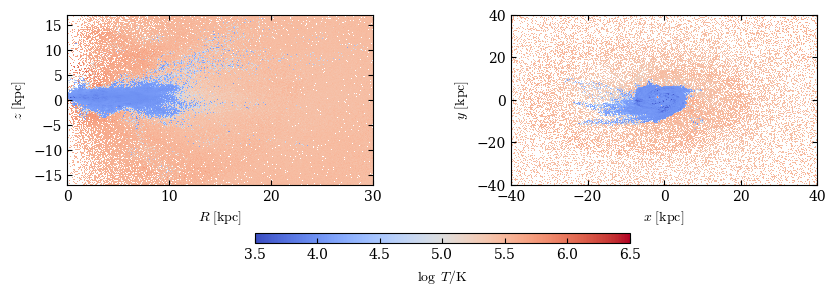

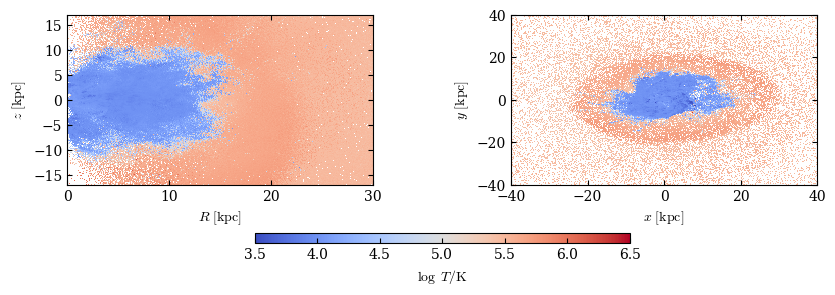

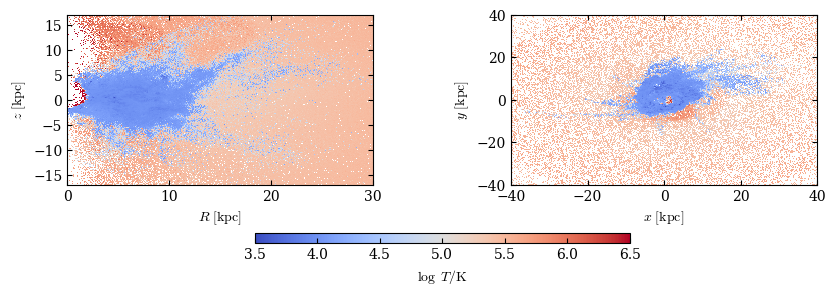

In [18]:
for iSnapshot in np.arange(50,501,50):
    print(iSnapshot)
    snapshot = sim.getSnapshot(iSnapshot)
    prof = sim.getProfiler(iSnapshot)
    xs,ys,zs = [snapshot.coords()[:,i] for i in range(3)]
    zs += 0.25 #disk is offset for some reason
    phis = np.arctan2(ys,xs)
    Rs = (xs**2+ys**2)**0.5
    rs = (Rs**2+zs**2)**0.5
    thetas = np.arccos(zs/rs)
    bins_Rs = np.arange(0.,40.1,0.1);  midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
    bins_zs = np.arange(-20.1,20.11,0.1); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
    Ts_cyl,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),statistic='median',bins=(bins_Rs,bins_zs))  
    bins_xs = np.arange(-40.1,40.11,0.1); midbins_xs = (bins_xs[1:]+bins_xs[:-1])/2
    bins_ys = np.arange(-40.1,40.11,0.1); midbins_ys = (bins_ys[1:]+bins_ys[:-1])/2
    inds    = np.abs(zs)<10
    Ts_faceon,_,_,bin_inds = scipy.stats.binned_statistic_2d(xs[inds],ys[inds],log(snapshot.Ts()[inds]),statistic='median',bins=(bins_xs,bins_ys)) 
    Tmin,Tmax = 3.5,6.5
    
    fig = pl.figure(figsize=(fig_width_full*1.1,3.15))
    gs = matplotlib.gridspec.GridSpec(1,2,wspace=0.45,right=0.99,left=0.03,width_ratios=(2,2))
    ax1 = fig.add_subplot(gs[0])
    mesh = pl.pcolormesh(midbins_Rs,midbins_zs,Ts_cyl.T,cmap='coolwarm',zorder=-100,vmin=Tmin,vmax=Tmax,shading='nearest') 
    pl.ylim(-17,17); pl.xlim(0,30)
    pl.xlabel(r'$R\ [{\rm kpc}]$')
    pl.ylabel(r'$z\ [{\rm kpc}]$')
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2 = fig.add_subplot(gs[1])
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))
    mesh = pl.pcolormesh(midbins_xs,midbins_ys,Ts_faceon.T,cmap='coolwarm',
                         zorder=-100,vmin=Tmin,vmax=Tmax,shading='nearest') 
    pl.xlabel(r'$x\ [{\rm kpc}]$')
    pl.ylabel(r'$y\ [{\rm kpc}]$')
    pl.ylim(-40,40); pl.xlim(-40,40)
    cb = pl.colorbar(mesh,ax=[ax1,ax2],orientation='horizontal',label=r'$\log\ T/{\rm K}$',
                     shrink=0.5,fraction=0.1,aspect=40,pad=0.2)
    pl.clim(Tmin,Tmax)
    pl.savefig(figdir+'snapshot_map_%d.png'%iSnapshot,bbox_inches='tight',dpi=300)

In [12]:
oxygen_cooling_arr = np.array([[float(x) for x in l.split()] for l in open('/mnt/home/jstern/gizmo_analysis/CoolingTables/GnatFerland12_cooling_ion_by_ion/cooling/datafile1H.txt').readlines()[20:]])

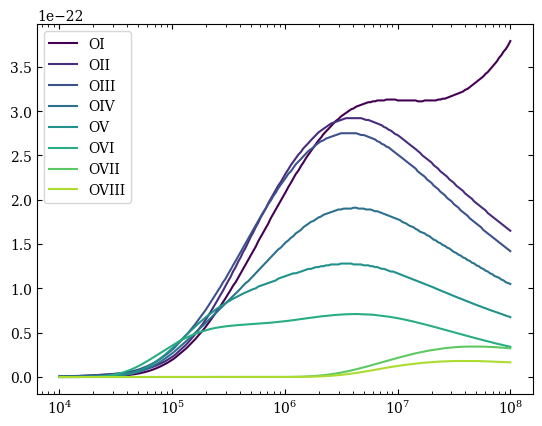

In [17]:
for i in range(1,9): 
    pl.semilogx(oxygen_cooling_arr[:,0],oxygen_cooling_arr[:,i]*0.2*5e-4,label='O%s'%ff.u.roman[i],
               c = pl.get_cmap('viridis')((i-1)/8))
pl.legend()

In [45]:
Lambda_OVI = np.interp(snapshot.Ts(), oxygen_cooling_arr[:,0],oxygen_cooling_arr[:,6])*un.erg*un.cm**3

In [46]:
nO = snapshot.rho()*un.g*un.cm**-3 * snapshot.dic[('PartType0','Metallicity')][:,4]/(16*cons.m_p)

In [47]:
OVI_emission = Lambda_OVI * snapshot.ne2nHs()*snapshot.nHs()*un.cm**-3 * nO * 10.**snapshot.ionFractions()

In [49]:
OVI_emission.to('erg/cm**3')

<Quantity [3.09545809e-34, 5.83981325e-34, 6.56282041e-34, ...,
           8.21600374e-36, 2.57080501e-36, 5.16915464e-36] erg / cm3>

In [ ]:
xs,ys,zs = [snapshot.coords()[:,i] for i in range(3)]
zs += 0.25 #disk is offset for some reason
phis = np.arctan2(ys,xs)
Rs = (xs**2+ys**2)**0.5
rs = (Rs**2+zs**2)**0.5
thetas = np.arccos(zs/rs)
bins_Rs = np.arange(0.,40.1,0.1);  midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(-20.1,20.11,0.1); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
OVIs_cyl,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,log(OVI_emission.value),statistic='median',
                                                       bins=(bins_Rs,bins_zs)) 

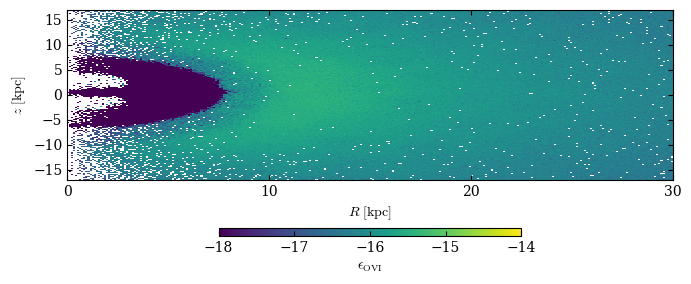

In [72]:
fig = pl.figure(figsize=(fig_width_full*1.1,3.15))
ax1 = pl.subplot(111)
mesh = pl.pcolormesh(midbins_Rs,midbins_zs,OVIs_cyl.T+log(midbins_Rs*3e21/2e5**2),cmap='viridis',zorder=-100,shading='nearest',
                    vmin=-30+22.5-10.5,vmax=-26+22.5-10.5) 
cb = pl.colorbar(mesh,ax=ax1,orientation='horizontal',label=r'$\epsilon_{\rm OVI}$',
                     shrink=0.5,fraction=0.1,aspect=40,pad=0.2)
pl.ylim(-17,17); pl.xlim(0,30)
pl.xlabel(r'$R\ [{\rm kpc}]$')
pl.ylabel(r'$z\ [{\rm kpc}]$')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))

#pl.savefig(figdir+'snapshot_map_%d.png'%iSnapshot,bbox_inches='tight',dpi=300)

In [69]:
d = 1200*un.Mpc 
A = log((4*np.pi*d**2/2e5**2).to('cm**2'))

UnitTypeError: Can only apply 'log10' function to dimensionless quantities